# Fine-tuning a ResNet-50 model

## Imports

In [1]:
import os
from pathlib import Path

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))
Path.cwd()

PosixPath('/home2/jgcw74/l3_project')

In [2]:
import dataset_processing.eurosat
import helpers

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import platform
import time

import einops
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms
import wandb
import safetensors.torch as st
from tqdm.autonotebook import tqdm

print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


In [4]:
np_rng = np.random.default_rng(42)
_ = torch.manual_seed(42)

In [5]:
dataset_processing.core.get_dataset_root()

PosixPath('/home2/jgcw74/datasets')

In [6]:
checkpoints_path = Path.cwd() / 'checkpoints' / 'resnet50'
checkpoints_path.mkdir(exist_ok=True)
checkpoints_path

PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50')

# EuroSAT (RGB) dataset

## Load dataset

In [7]:
base_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),  # scaling handles by normalise below
    dataset_processing.core.RSNormaliseTransform(0, 2750),
    # normalise to [0, 1] (based on maximums used in original paper)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True),  # shift to mean 0 and std 1

    # scale as expected by ResNet (see https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights)
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
])
wrapped_base_transforms = dataset_processing.core.tensor_dict_transform_wrapper(base_transforms)

training_transforms = transforms.Compose([
    base_transforms,
    # Randomised transforms:
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(0, shear=0.2),  # Shear with range 0.2
    # transforms.RandomAffine(0, scale=(1., 1.2)),  # Zoom in with range 0.2
])
wrapped_training_transforms = dataset_processing.core.tensor_dict_transform_wrapper(training_transforms)

In [8]:
eurosat_train_ds = dataset_processing.eurosat.get_base_dataset(
    "train", bands=("B04", "B03", "B02"),  # RGB bands
    transforms=wrapped_training_transforms, download=False
)
eurosat_val_ds = dataset_processing.eurosat.get_base_dataset(
    "val", bands=("B04", "B03", "B02"),  # RGB bands
    transforms=wrapped_base_transforms, download=False
)

print(f"There are {len(eurosat_train_ds)} training samples and {len(eurosat_val_ds)} validation samples.")
print("Image dimensions and label:", eurosat_train_ds[0]["image"].size(), eurosat_train_ds[0]["label"])

There are 16200 training samples and 5400 validation samples.
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)


### Visualise some images

In [9]:
def rescale_image_range(image: torch.Tensor) -> torch.Tensor:
    return (image - image.min()) / (image.max() - image.min())

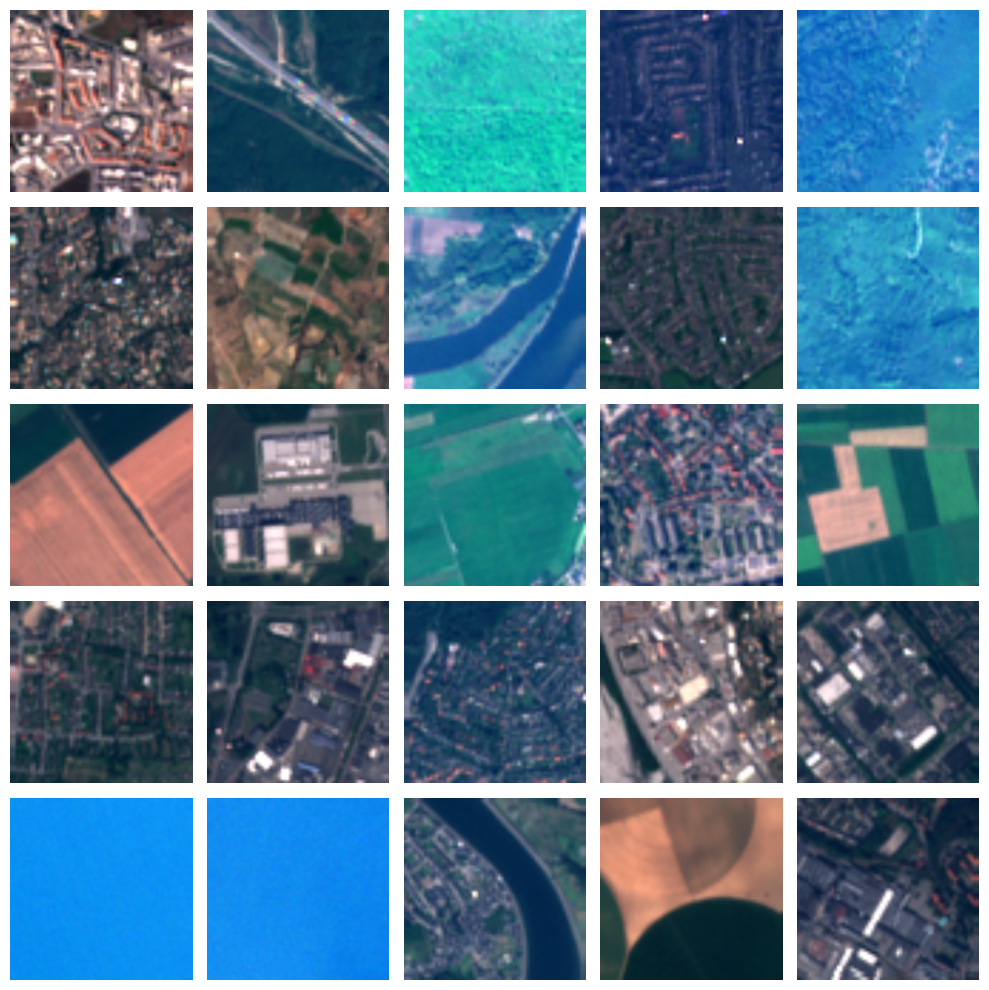

In [10]:
random_indices = np_rng.choice(len(eurosat_train_ds), size=25, replace=False)
plt.figure(figsize=(10, 10), tight_layout=True)
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(einops.rearrange(rescale_image_range(eurosat_train_ds[idx]["image"]), "c h w -> h w c"))
    plt.axis("off")
plt.show()

## Training/Fine-tuning

In [11]:
train_dataloader = torch.utils.data.DataLoader(
    eurosat_train_ds, batch_size=32, num_workers=4, shuffle=True, drop_last=True
)
val_dataloader = torch.utils.data.DataLoader(
    eurosat_val_ds, batch_size=32, num_workers=4, shuffle=False, drop_last=False
)
validation_iterator = iter(dataset_processing.core.cycle(val_dataloader))

### Initialise model

In [12]:
resnet50_model = helpers.models.FineTunedResNet50(num_classes=len(eurosat_train_ds.classes))

In [13]:
model_to_train = resnet50_model.to(device)

### Set up training criteria and optimiser

Following the regime of the original EuroSAT paper:
Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226. https://doi.org/10.1109/JSTARS.2019.2918242

### Fine tune final layer

In [15]:
model_to_train.freeze_layers(1)
print(model_to_train)

FineTunedResNet50(
  > 6 layers frozen: Conv2d, BatchNorm2d, Sequential, Sequential, Sequential, Sequential <
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [14]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
decay = 1e-6
momentum = 0.9

In [17]:
parameters_to_optimise = filter(lambda p: p.requires_grad, model_to_train.parameters())
optimiser = torch.optim.SGD(
    parameters_to_optimise, lr=learning_rate, weight_decay=decay, momentum=momentum, nesterov=True
)

### Track with Weights & Biases

In [18]:
run = False
if run:
    run = wandb.init(
        save_code=True,
        project="evaluating_xAI_for_RS",
        name="",
        notes="",
        tags=[],
        id="",  # REMEMBER TO CHANGE
        resume="never",  # 'allow' to resume a crashed run
        config={
            "dataset": "EuroSAT",
            "transforms": repr(training_transforms),
            "batch_size": train_dataloader.batch_size,

            "model": {
                "name": model_to_train.__class__.__name__,
                "architecture": repr(model_to_train),
            },
            "training": {
                "optimiser": repr(optimiser),
                "learning_rate": learning_rate,
            },

            "initialisation_time": time.asctime()
        }
    )

### Training loop

In [ ]:
for epoch in tqdm(range(20), desc="Epochs"):
    training_loss_arr = np.zeros(0)
    training_acc_arr = np.zeros(0)

    with tqdm(desc="Batches", total=len(train_dataloader), leave=True) as prog_bar2:
        for i, data in enumerate(train_dataloader):
            images = data["image"]
            labels: torch.Tensor = data["label"]

            loss, acc = helpers.ml.train_step(
                model_to_train, images, labels, criterion,
                optimiser
            )
            training_loss_arr = np.append(training_loss_arr, loss)
            training_acc_arr = np.append(training_acc_arr, acc)

            prog_bar2.update()
            if i > 0 and i % 100 == 0:
                training_mean_loss = training_loss_arr.mean()
                training_mean_acc = training_acc_arr.mean()
                prog_bar2.set_postfix(train_loss=training_mean_loss, train_acc=training_mean_acc)
                if run:
                    run.log({
                        "loss/train": training_mean_loss,
                        "accuracy/train": training_mean_acc,
                        "total_steps_trained": (epoch * len(train_dataloader)) + i,
                    })

                training_loss_arr = np.zeros(0)
                training_acc_arr = np.zeros(0)

    val_mean_loss, val_mean_acc = helpers.ml.validation_step(
        model_to_train, criterion, validation_iterator, len(val_dataloader)
    )
    if run:
        run.log({
            "loss/validation": val_mean_loss,
            "accuracy/validation": val_mean_acc,
        })

        if epoch != 0 and epoch % 10 == 0:
            st.save_model(model_to_train,
                          checkpoints_path / f"{model_to_train.__class__.__name__}_epoch{epoch:03}_weights.st")

In [21]:
st.save_model(model_to_train,
              checkpoints_path / f"{model_to_train.__class__.__name__}_final_weights({val_mean_acc:.3f}).st")

### Fine tune through full network

In [33]:
model_to_train.unfreeze_layers()
print(model_to_train)

FineTunedResNet50(
  > 0 layers frozen:  <
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

In [34]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
decay = 1e-6
momentum = 0.9

In [35]:
parameters_to_optimise = filter(lambda p: p.requires_grad, model_to_train.parameters())
optimiser = torch.optim.SGD(
    parameters_to_optimise, lr=learning_rate, weight_decay=decay, momentum=momentum, nesterov=True
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=np.float_power(10, -1 / 4), patience=5,
                                                       threshold=0.005)

In [ ]:
with tqdm(total=50, desc="Epochs") as prog_bar1:
    for epoch in range(50):
        training_loss_arr = np.zeros(0)
        training_acc_arr = np.zeros(0)

        with tqdm(desc="Batches", total=len(train_dataloader), leave=False) as prog_bar2:
            for i, data in enumerate(train_dataloader):
                images = data["image"]
                labels: torch.Tensor = data["label"]

                loss, acc = helpers.ml.train_step(
                    model_to_train, images, labels, criterion,
                    optimiser
                )
                training_loss_arr = np.append(training_loss_arr, loss)
                training_acc_arr = np.append(training_acc_arr, acc)

                prog_bar2.update()
                if i > 0 and i % 100 == 0:
                    training_mean_loss = training_loss_arr.mean()
                    training_mean_acc = training_acc_arr.mean()
                    prog_bar2.set_postfix(train_loss=training_mean_loss, train_acc=training_mean_acc)
                    if run:
                        run.log({
                            "loss/train": training_mean_loss,
                            "accuracy/train": training_mean_acc,
                            "total_steps_trained": (epoch * len(train_dataloader)) + i,
                        })

                    training_loss_arr = np.zeros(0)
                    training_acc_arr = np.zeros(0)

        val_mean_loss, val_mean_acc = helpers.ml.validation_step(
            model_to_train, criterion, validation_iterator, len(val_dataloader)
        )

        if run:
            run.log({
                "loss/validation": val_mean_loss,
                "accuracy/validation": val_mean_acc,
            })

            if epoch != 0 and epoch % 10 == 0:
                st.save_model(model_to_train,
                              checkpoints_path / f"{model_to_train.__class__.__name__}_epoch{epoch:03}_ft_weights.st")

        scheduler.step(val_mean_loss)
        prog_bar1.update()
        current_lr = scheduler.get_last_lr()[0]
        prog_bar1.set_postfix(val_loss=val_mean_loss, lr=current_lr)
        if current_lr < 0.0001:
            print('Early stop on low learning rate (plateaued after reduction)')
            break

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/506 [00:00<?, ?it/s]

In [44]:
print(f"Trained for {epoch} epochs ending at lr {scheduler.get_last_lr()[0]:.10f}")

Trained for 35 epochs ending at lr 0.0001000000


In [38]:
st.save_model(model_to_train,
              checkpoints_path / f"{model_to_train.__class__.__name__}_final_ft_weights({val_mean_acc:.3f}).st")

In [18]:
st.load_model(model_to_train, checkpoints_path / "FineTunedResNet50_final_ft_weights(0.989).st")

(set(), [])

In [19]:
final_val_mean_loss, final_val_mean_acc = helpers.ml.validation_step(
    model_to_train, criterion, validation_iterator, len(val_dataloader)
)

Validating:   0%|          | 0/169 [00:00<?, ?it/s]

In [20]:
final_val_mean_loss, final_val_mean_acc

(0.048589915838794004, 0.9892751479289941)

### Upload final model stats

In [ ]:
run.summary["num_epochs_trained"] = 0
run.summary["loss/validation"] = final_val_mean_loss
run.summary["accuracy/validation"] = final_val_mean_acc